In [28]:
try:
    from evlist_corr import *
except:
    libpath="https://github.com/toastmaker/ccf/raw/master/notebooks/evlist_corr.py"
    import requests
    flib=requests.get(libpath)
    exec(flib.text)
    
corr_pos=[0,1]

In [2]:
ifile="/data/munz/astro/time/lcurve_1ms_pack1.npz"
import numpy as np
dat=np.load(ifile)

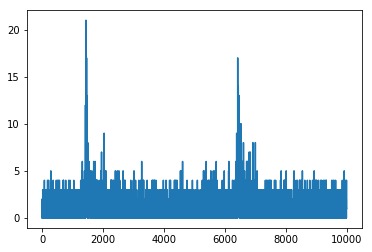

In [6]:
%matplotlib inline
from matplotlib import pyplot as pl
pl.plot(dat['set1'][0])

In [10]:
mpos1=np.argmax(dat['set1'][:,:5000],axis=1)
mpos2=np.argmax(dat['set1'][:,5000:],axis=1)

In [55]:
cent_bin,cent_num=10,5
def barytest(lcur1,lcur2,fac=50,wsiz=10,dt=0,nshi=10,poe=2):
    nqin=130*fac//2
    cbeg=(qmid-qsiz)*fac*nshi
    csiz=2*qsiz*fac*nshi
    ic=(int)(dt*fac*nshi)
    if cbeg+csiz>len(lcur1):
        csiz=len(lcur1)-cbeg-nshi
        csiz=(csiz//nshi)*nshi
    if nqin*nshi+ic>len(lcur2):
        nqin=(len(lcur2)-ic)//nshi-2
    #print(cbeg,csiz,nqin)
    pos=[]
    for ib in range(nshi):
        sb1=lcur1[ib+cbeg:ib+cbeg+csiz].reshape(csiz//nshi,nshi).mean(1)*nor1
        sb2=lcur2[ib+ic:ib+ic+nqin*nshi].reshape(nqin,nshi).mean(1)*nor2
        cur=np.correlate(sb1,sb2[::-1],"valid")
        mid=np.argmax(cur)
        if mid>len(cur)-wsiz: mid=len(cur)-wsiz
        elif mid<wsiz: mid=wsiz
        pos.append((cur[mid-wsiz:mid+wsiz]**poe*np.r_[mid-wsiz:mid+wsiz]).sum()/(cur[mid-wsiz:mid+wsiz]**poe).sum())
    return np.array(pos)/fac-corr_pos[0]-fac/corr_pos[1]

fac=50
gsiz=20 #window size
def baryset(lindat,fac=50,dt=0,nshi=20,tstart=110,subsam=10,poe=2,lsiz=0):
    '''repeating same test `niter` times
    '''
    rep=[]
    if lsiz==0: lsiz=(len(lindat[9])-1)//2
    qgrp=1000//fac
    rgrp=1000//(nshi*fac)
    nshi=(qgrp//rgrp)*rgrp
    lsiz=fac*nshi*rgrp
    print("factor: %.1f ms"%(1000/nshi/rgrp))
    for lin in lindat:
        lc1=lin[:lsiz].reshape(lsiz//rgrp,rgrp).sum(1)
        lc2=lin[5000:5000+lsiz].reshape(lsiz//rgrp,rgrp).sum(1)
        rep.append(barytest(lc1,lc2,fac=fac,wsiz=gsiz,dt=dt,nshi=nshi,poe=poe))
    return np.array(rep)


In [67]:
lsiz=4999
l=2
nshi=11
fac=30
qgrp=1000//fac
rgrp=1000//(nshi*fac)
nshi=(qgrp//rgrp)
lsiz=fac*nshi*rgrp
lsiz=(lsiz//rgrp)*rgrp
nor1,nor2=1,1
lc1=dat['set1'][l][:lsiz].reshape(lsiz//rgrp,rgrp).sum(1)
lc2=dat['set1'][l][5000:5000+lsiz].reshape(lsiz//rgrp,rgrp).sum(1)
qmid,qsiz=2,1
#ok1=barytest(lc1,lc2,fac=30,nshi=nshi)
fac,nshi,rgrp,qgrp

(30, 11, 3, 33)

In [169]:
cbeg=(qmid-qsiz)*fac*nshi
csiz=2*qsiz*fac*nshi
klokal={}

def barytest2(lcur1,lcur2,fac=50,nshi=10,wsiz=10,dt=0,poe=2,rep=0):
    #constant binning 1 ms
    tbin=1000//fac
    nqin=(len(lcur2)//tbin)#130*fac//2 #??
    klokal['bin']=tbin
    
    cbeg=(qmid-qsiz)*fac*tbin
    csiz=2*qsiz*fac*tbin
    mqin=2*qsiz*fac
    ic=(int)(dt*fac*tbin)
    
    if cbeg+csiz+tbin>len(lcur1):
        csiz=len(lcur1)-cbeg-tbin
        mqin=csiz//tbin
        csiz=mqin*tbin
    if (nqin+1)*tbin+ic>len(lcur2):
        nqin=(len(lcur2)-ic)//tbin-2
    #print(tbin,mqin,nqin,csiz)
    klokal['win1']=[cbeg,csiz]#,nqin)
    pos=[]
    for i in range(nshi,2*nshi):
        ib=int(tbin*i/nshi)
        sb1=lcur1[ib+cbeg:ib+cbeg+mqin*tbin].reshape(mqin,tbin).mean(1)
        sb2=lcur2[ib+ic:ib+ic+nqin*tbin].reshape(nqin,tbin).mean(1)
        cur=np.correlate(sb1,sb2[::-1],"valid")
        if rep==1: return cur
        mid=np.argmax(cur)
        if mid>len(cur)-wsiz: mid=len(cur)-wsiz
        elif mid<wsiz: mid=wsiz
        pos.append((cur[mid-wsiz:mid+wsiz]**poe*np.r_[mid-wsiz:mid+wsiz]).sum()/(cur[mid-wsiz:mid+wsiz]**poe).sum())
    return np.array(pos)*tbin/1000#/fac-corr_pos[0]-fac/corr_pos[1]


(0.0022830761460749536,
 array([0.26014855, 0.26497471]),
 0.002246001324797323,
 array([0.26016267, 0.26511812]))

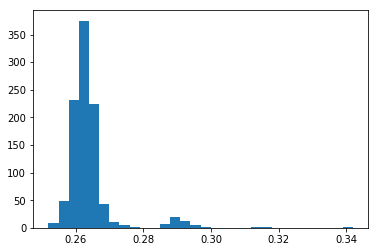

In [148]:

def baryset2(lindat,fac,lsiz=4990,nshi=10,wsiz=10,poe=2):
    out=[]
    for lin in lindat:
        out.append(barytest2(lin[:lsiz],lin[5000:5000+lsiz],fac,nshi,wsiz=wsiz,poe=poe))
    return np.array(out)
qtest2=baryset2(dat['set1'],fac=20,nshi=20,wsiz=6)
st1=np.median(qtest2,1)
st2=np.percentile(qtest2,[20,80],axis=1).sum(0)/2
dm2=np.percentile(st2,[20,80])
sel2=(st2>(3*dm2[0]-dm2[1])/2)*(st2<(3*dm2[1]-dm2[0])/2)
#sel2=(st2>dm2[0])*(st2<dm2[1])

dm1=np.percentile(st1,[20,80])
sel=(st1>(3*dm1[0]-dm1[1])/2)*(st1<(3*dm1[1]-dm1[0])/2)
pl.hist(st2,30);
st1[sel].std(),dm1,st2[sel2].std(),dm2

In [149]:
sum(sel),sum(sel2)

(885, 860)

In [131]:
qtest2=baryset2(dat['set1'],fac=20,nshi=10,wsiz=6)
brep=[]
for st1 in qtest2.T:
    #st1=qtest2[:,0]
    dm1=np.percentile(st1,[20,80])
    sel=(st1>dm1[0])*(st1<dm1[1])
    #pl.hist(np.mean(qtest2,1),30);
    brep.append([st1[sel].std()]+list(dm1))
brep

[[0.0013897424502617049, 0.26121926923680744, 0.26628373969787006],
 [0.0014180425414636968, 0.2609481703389259, 0.2660752638866035],
 [0.001397932410967186, 0.26067480981937563, 0.2656628340537533],
 [0.0014231758279383236, 0.2603987708333759, 0.2655341553929422],
 [0.0014200125481224463, 0.2601218742070106, 0.2651978412261576],
 [0.001425185858197859, 0.2599719950590991, 0.2649917044154074],
 [0.0014277734504037853, 0.25973019704696443, 0.26483703146208304],
 [0.0014060880728736312, 0.25971537106989806, 0.26467937802526764],
 [0.0013522726592545098, 0.2594861770540374, 0.2643862232202982],
 [0.0013272719520805551, 0.25925330436070554, 0.2642380180184129]]

In [128]:
crep=[]
for k in range(5,15):
    st1=np.median(qtest2[:,k:],1)
    dm1=np.percentile(st1,[20,80])
    sel=(st1>dm1[0])*(st1<dm1[1])
    crep.append(st1[sel].mean())
crep

[0.26398835017662575,
 0.2640582502804949,
 0.26412177793314007,
 0.2641793593023696,
 0.2642292664661383,
 0.2642295984328157,
 0.2642249640370497,
 0.2641965108264319,
 0.2641324967662887,
 0.264117071309151]

In [168]:
hbest=dict(fac=30,nshi=10,wsiz=5,poe=1.4)
rep=[]
for i in range(1,7):
    qtest2=baryset2(dat['set%i'%i],**hbest)
    st1=np.median(qtest2,1)
    dm1=np.percentile(st1,[20,80])
    #sel=(st1>dm1[0])*(st1<dm1[1])
    sel=(st1>(3*dm1[0]-dm1[1])/2)*(st1<(3*dm1[1]-dm1[0])/2)
    rep.append([np.median(st1),st1[sel].std(),sum(sel)])
rep
#dm1[1]-dm1[0]

[[0.14655820269283582, 0.0011039569375849918, 850],
 [0.14638190912838786, 0.0011329236655088807, 871],
 [0.14647354356295111, 0.0011017308171909412, 864],
 [0.14643240255689804, 0.0010821426512830008, 856],
 [0.1464148931252242, 0.0010773995542414224, 861],
 [0.14637386516876147, 0.0011197147602997892, 849]]

In [163]:
qtest2=baryset2(dat['set%i'%i],fac=30,nshi=10,wsiz=5,poe=1.4)
st1=np.median(qtest2,1)
dm1=np.percentile(st1,[20,80])
sel=(st1>(3*dm1[0]-dm1[1])/2)*(st1<(3*dm1[1]-dm1[0])/2)
st1[sel].std(),sum(sel)

(0.0011197147602997892, 849)

In [170]:
bad=np.where(sel==False)[0]
qtest2[bad[2]],st1[bad[2]]

(array([0.18406877, 0.18379876, 0.18370932, 0.18327428, 0.18336395,
        0.18324733, 0.15078374, 0.15072955, 0.15095018, 0.15079665]),
 0.18326080121357263)

In [179]:
bad

array([  1,  11,  15,  30,  35,  38,  46,  72,  74,  75,  77,  86,  89,
        97, 100, 105, 107, 108, 114, 116, 130, 135, 138, 141, 142, 152,
       162, 164, 169, 182, 188, 190, 194, 200, 204, 206, 209, 213, 219,
       225, 235, 246, 253, 262, 270, 281, 291, 294, 296, 299, 307, 308,
       328, 337, 347, 357, 358, 361, 372, 375, 399, 405, 409, 425, 427,
       428, 448, 465, 476, 514, 531, 533, 537, 550, 556, 566, 568, 573,
       575, 583, 585, 591, 593, 594, 612, 613, 641, 645, 646, 647, 648,
       649, 652, 657, 668, 669, 674, 680, 682, 688, 697, 711, 715, 718,
       719, 725, 736, 739, 741, 744, 752, 755, 763, 774, 786, 787, 794,
       796, 797, 805, 812, 813, 814, 819, 837, 843, 845, 846, 847, 855,
       856, 866, 867, 868, 875, 895, 896, 898, 902, 916, 931, 943, 950,
       954, 955, 957, 970, 982, 985, 990, 992])

{'bin': 33, 'win1': [990, 1980]}

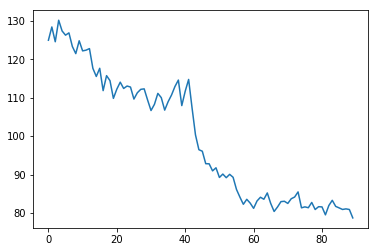

In [181]:
lin=dat['set1'][40]
curx=barytest2(lin[:lsiz],lin[5000:5000+lsiz],rep=1,**hbest)
pl.plot(curx)
klokal

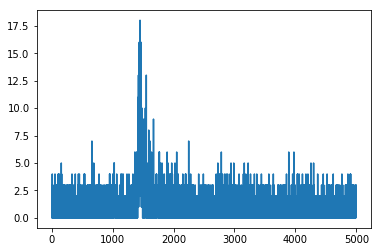

In [175]:
pl.plot(lin[5000:])

In [74]:
from scipy import optimize as op
#op.fmin(maxiter=10)

In [164]:
hbest=dict(fac=30,nshi=10,wsiz=5,poe=1.4)

In [165]:
hbest

{'fac': 30, 'nshi': 10, 'wsiz': 5, 'poe': 1.4}

In [166]:
qtest3=baryset2(dat['set%i'%i],**hbest)